In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils
# 关闭 Tensorflow 的 warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
utils.gpu_limitation_config(device=0,memory=30)

1. 该练习帮助你**巩固深度学习模型的设计和训练技巧**
   1. 运用所有学习到的知识，搭建一个卷积神经网络，训练一个 `CIFAR-100` 数据集分类器
   2. 网络可以自己设计，也可以选择已有的架构，例如 `VGGNet`，`ResNet` 等，或者在已有的架构上改进模型
   3. **注意我们提及到的所有深度学习模型训练技巧**，例如Dropout，BatchNorm，图像增广
      * 如果时间允许，你甚至可以尝试每次只引入一种技巧，观察每种技巧的引入对模型带来的影响，时刻关注模型的训练状态，这个调整的过程会非常耗费时间和精力，但有助于你更深入了解深度学习
   4. **你能让模型在测试集上的准确率达到 90% 以上吗？**

In [4]:
def ResNet(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        # 图像增广
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),

        # 归一化和缩放
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.Resizing(width=96,height=96),

        # 第一层
        ch3.ResNetBlock1(),

        # 后续四层残差块
        ch3.ResNetBlock(num_channels=64,num_residuals=2,first_block=True),
        ch3.ResNetBlock(num_channels=128,num_residuals=2),
        ch3.ResNetBlock(num_channels=256,num_residuals=2),
        ch3.ResNetBlock(num_channels=512,num_residuals=2),
        
        # 全剧平均池化，得到输出概率
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
        ])

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [6]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [7]:
y_train = tf.keras.utils.to_categorical(y_train.flatten(), num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test.flatten(), num_classes=100)

In [9]:
model = ResNet(input_shape=(32,32,3),num_class=100)

In [ ]:
model = ch3.train(model, (x_train, y_train), (x_test, y_test), epochs=1, batch_size=128, lr=0.1,verbose=1)

### **通过异步CPU和缓存来加速图像增广**

我们已经发现了图像增广应用到 CNN 后严重影响了训练的速度，并且我们明确：
* `tf.keras.layers` 中提供的图像变换**在 GPU 上完成**，速度会快于 CPU
* `tf.keras.preprocessing.image.ImageDataGenerator` 提供的图像变换**在 CPU 上完成**，速度要慢于 `tf.keras.layers` API

深入分析图像增广导致训练缓慢的原因，包括：
* **GPU 适合进行大规模的矩阵乘法运算**，在模型中加入**图像增广层**会使计算**瓶颈**全部堆积在图像的随即变换上，**GPU 并不适合做这种变换**
* 我们应该**让 GPU 做自己最适合的事情**，也就是真正的模型推理的部分
* 在模型训练时，GPU 忙于处理模型相关的计算（前向推理，后向梯度反传），但此时 **CPU 是空闲的**

因此，一种加速图像增广的方法是**在模型处理当前批量数据的前向推理和梯度反传更新时，让空闲的 CPU 提前准备下一批量的图片，提前做好图像增广**
* 将处理好的图像放入缓存，**到下一个批次时，GPU 只需要直接从内存读取处理好的图像即可**

下面演示这种**将图像增广应用到数据集**上的异步训练方法

In [25]:
# 创建数据增广层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# 归一化和缩放
rescale_and_resizing = tf.keras.Sequential([
    tf.keras.layers.Resizing(width=32,height=32),
    tf.keras.layers.Rescaling(1./255)
])

In [26]:
def preprocessing_data(dataset : tf.data.Dataset, training : bool=True, batch_size : int=64):
    # 训练时，使用数据增广
    if training:
        dataset = dataset.map(lambda x, y: (data_augmentation(x,training=True), y), 
                              num_parallel_calls=tf.data.AUTOTUNE) # 多线程加速，线程数自动调整
        dataset = dataset.shuffle(1024) # 打乱数据
    
    # 归一化和缩放
    dataset = dataset.map(lambda x, y: (rescale_and_resizing(x), y), 
                          num_parallel_calls=tf.data.AUTOTUNE) # 多线程加速，线程数自动调整
    # 设置批量大小和缓冲区大小
    # GPU 能从缓冲区中预取数据，CPU 能在 GPU 训练时预处理数据
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

按照如下方式，就可以**定义数据迭代器啦**

In [27]:
# 创建 tensorflow 数据集
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# 数据预处理
batch_size = 128
train_ds = preprocessing_data(train_ds, training=True, batch_size=batch_size)
test_ds = preprocessing_data(test_ds, training=False, batch_size=batch_size)

接下来，稍微调整一下训练函数
* 在函数内**创建我们需要的数据迭代器** `train_ds`，模型能直接使用这两个迭代器
* 让模型推理之前，由于我们将归一化 `Rescaling` 和尺寸变化 `Resizing` 分离出模型，在**模型推理前需要先调用变换层**
    * 例如，我们在送入 `classification_prediction` 之前，先对特征 `X` 调用了 `rescale_and_resizing(X)`

In [28]:
def train(model, train_tensors : tuple, test_tensors : tuple, 
          batch_size : int=64, epochs : int=10, lr : float=0.01, verbose : int=1):
    """
    Parameters
    ----------
    train_tensors, test_tensors : tuple
        训练 / 测试数据的 `tf.Tensor` 元组，元组包含两个元素\n
        `tensors[0]` 表示输入特征，`tensors[1]` 表示标签
    """
    # 创建损失函数和优化器
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # 度量函数
    accuracy = tf.keras.metrics.categorical_accuracy
    
    # 创建动画实例
    animator = utils.Animator(xlabel="Epochs",legend=(("train loss",),("train acc","test acc")),
                        xlim=[1,epochs],ncols=2,figsize=(10,4),fmts=(("-",),("m--","g-,"))) 

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = preprocessing_data(train_ds, training=True, batch_size=batch_size)

    for epoch in range(epochs):
        # 从 train_ds 中获取一个批量的数据
        for x_batch, y_batch in train_ds:
            # 跟踪梯度
            with tf.GradientTape() as tape:
                prob = model(x_batch,training=True)
                loss = loss_func(y_batch,prob)
            
            # 选择参数，计算梯度
            weights = model.trainable_variables
            grads = tape.gradient(loss,weights)
            optimizer.apply_gradients(zip(grads,weights))
        
        # 计算评估指标，添加到动画
        if epoch == 0 or (epoch+1)%verbose == 0: # 每 verbose 次更新一次
            # 做出预测
            # 注意这里需要施加 rescale_and_resizing
            y_train_prob = ch3.classification_predict(
                model,(rescale_and_resizing(train_tensors[0]),),batch_size,label=False)
            y_test_prob = ch3.classification_predict(
                model,(rescale_and_resizing(test_tensors[0]),),batch_size,label=False)
            
            train_loss = tf.reduce_mean(loss_func(train_tensors[1],y_train_prob)).numpy()
            train_acc = tf.reduce_mean(accuracy(train_tensors[1],y_train_prob)).numpy()
            test_acc = tf.reduce_mean(accuracy(test_tensors[1],y_test_prob)).numpy()

            animator.add(epoch+1,(train_loss,),ax=0) # 子图1
            animator.add(epoch+1,(train_acc,test_acc),ax=1) # 子图2
    
    return model

最后，我们调整一下模型的定义，**去除掉里面的图像增广和变换，只保留 CNN 的计算**

In [29]:
def ResNetPlus(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        # 第一层
        ch3.ResNetBlock1(),
        # 后续四层残差块
        ch3.ResNetBlock(num_channels=64,num_residuals=2,first_block=True),
        ch3.ResNetBlock(num_channels=128,num_residuals=2),
        tf.keras.layers.Dropout(0.5),
        ch3.ResNetBlock(num_channels=256,num_residuals=2),
        ch3.ResNetBlock(num_channels=512,num_residuals=2),
        # 全剧平均池化，得到输出概率
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
        ])

In [32]:
model = ResNetPlus(input_shape=(32,32,3),num_class=100)

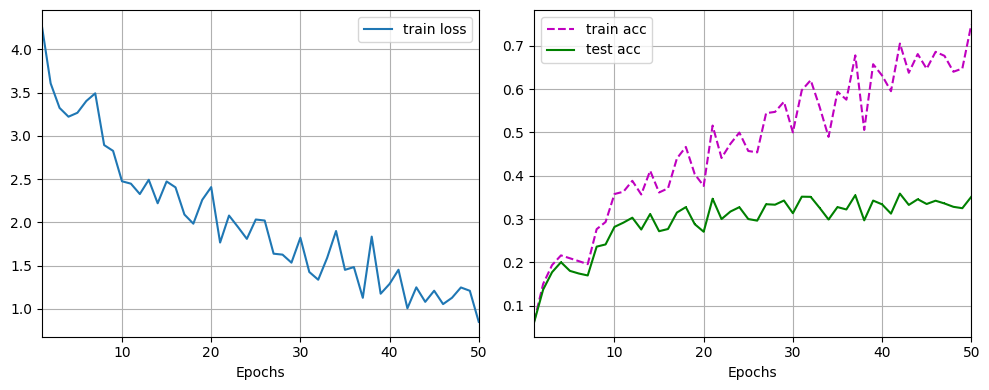

In [33]:
model = train(model, (x_train, y_train), (x_test, y_test), epochs=80, batch_size=128, lr=0.01,verbose=1)

可以看到模型的训练速度提升了 10 多倍
* **之前迭代一次模型需要 10 分钟，现在只需要不到 1 分钟**
* 如果**继续增大** `batch_size`，模型的训练速度还可以更快

----